<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score

## Подготовка данных

In [2]:
data = pd.read_csv('Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Удалим колонки, которые не понадобятся для исследования:

In [4]:
data = data.drop(columns = ['CustomerId', 'RowNumber', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Исправим названия колонок и приведём к нижнему регистру:

In [5]:
data.columns = map(str.lower, data.columns)
data = data.rename(columns = 
                   {'creditscore':'credit_score', 'numofproducts':'num_of_products', 'hascrcard':'has_cr_card', 'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'})
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
for column in data.columns:
    print(column)
    print(data[column].value_counts()) 
    print()

credit_score
850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: credit_score, Length: 460, dtype: int64

geography
France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

gender
Male      5457
Female    4543
Name: gender, dtype: int64

age
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: age, Length: 70, dtype: int64

tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

balance
0.00         3617
130170.82       2
105473.74       2
85304.27        1
159397.75       1
             ... 
81556.89        1
112687.69       1
108698.96       1
238387.56       1
130142.79       1
Name: balance, Length: 6382, dtype: int64

num_of_products
1    5084
2    4590
3     266
4      60
Name: num_of_products, dtype: int64

has_c

Text(0, 0.5, 'Количество человек')

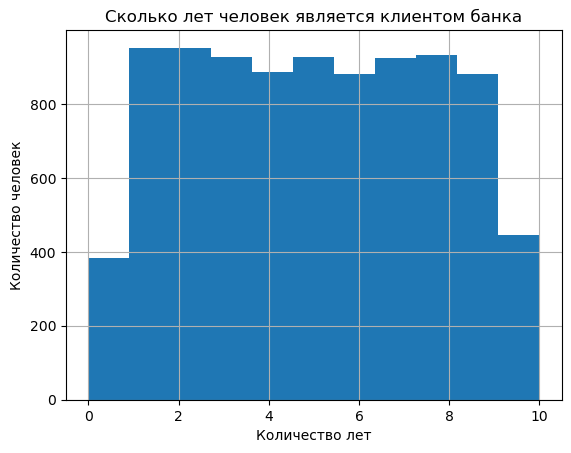

In [7]:
data['tenure'].hist(bins=11)
plt.title('Сколько лет человек является клиентом банка')
plt.xlabel('Количество лет')
plt.ylabel('Количество человек')

Заменим пропуски в столбце "tenure" с информацией о количестве лет, на протяжение которых человек является клиентом банка средним значением по категориям: кредитный рейтинг, количество продуктов банка, пол и страна. Оставшиеся пропуски заменим средним. И заменим тип данных на цельночисленный.

In [8]:
data['tenure'] = data['tenure'].fillna(data.groupby(['credit_score', 'num_of_products', 'geography', 'gender'])['tenure'].transform('mean'))
data['tenure'] = data['tenure'].fillna(data['tenure'].mean())
data = data.astype({'tenure':'int'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int32  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 820.4+ KB


Преобразуем категориальные признаки geography, gender  в численные техникой прямого кодирования, или отображения (OHE).

In [9]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Вывод:
Нами изучен датасет, состоящий из 10 000 строк и 14 колонок с информацией о клиентах банка. Мы изменили названия колонок в дтафрейме и привели к нижнему регистру, заполнили пропуски в периоде, в течение которогоо клиент является клиентом банка, избавились от ненужной информации(столбцы с фамилией клиентов и индексом строки). Заменили тип данных и преобразовали категориальные признаки в численные. Так же отметили, что большая часть клиентов - мужчины, >50% клиентов банка из Франции, 3617 клиентов имеют на болансе 0.

## Исследование задачи

In [10]:
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=2202, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              random_state=2202, stratify=target_valid)
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


In [11]:
numeric = ['credit_score', 'age','tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [12]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [13]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
528,-0.808823,0.876720,-0.693463,1.237282,-0.916357,1,0,-1.076265,1,0,0
9024,-0.104759,0.780294,0.370584,0.231110,0.791140,0,1,-1.504936,0,0,0
7043,-0.570683,-0.473242,-1.048145,0.201864,0.791140,0,1,0.975844,1,0,1
9177,-2.040934,-1.051797,-0.693463,1.032286,-0.916357,1,0,0.637078,1,0,0
6653,-0.436083,-1.533926,1.079948,1.953861,0.791140,1,1,0.276386,1,0,1


In [14]:
data_ohe['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

In [15]:
data_ohe['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Дерево решений:

In [16]:
best_model_tree = None
best_depth = 0
best_result = 0
for depth in range(1,21):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_tree.fit(features_train, target_train)
    predictions = model_tree.predict(features_valid)
    print('max_depth:', depth,'F1:', f1_score(target_valid, predictions))
    result = f1_score(predictions, target_valid)
    if best_result < result:
        best_depth = depth
        best_result = result
        best_model_tree = model_tree
print("Лучшая F-мера", best_result, 'cо значением глубины =', depth)
    

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.5444444444444445
max_depth: 3 F1: 0.4067796610169492
max_depth: 4 F1: 0.4456721915285451
max_depth: 5 F1: 0.5932203389830508
max_depth: 6 F1: 0.5591397849462365
max_depth: 7 F1: 0.5714285714285714
max_depth: 8 F1: 0.5822784810126582
max_depth: 9 F1: 0.5780346820809248
max_depth: 10 F1: 0.565880721220527
max_depth: 11 F1: 0.5741496598639456
max_depth: 12 F1: 0.5672436750998668
max_depth: 13 F1: 0.5331599479843953
max_depth: 14 F1: 0.5229591836734694
max_depth: 15 F1: 0.528160200250313
max_depth: 16 F1: 0.5264452644526446
max_depth: 17 F1: 0.5152625152625152
max_depth: 18 F1: 0.500616522811344
max_depth: 19 F1: 0.5054413542926239
max_depth: 20 F1: 0.5018181818181818
Лучшая F-мера 0.5932203389830508 cо значением глубины = 20


Случайный лес:

In [17]:
best_model_forest = None
best_est_forest = 0
best_depth_forest = 0
best_result_forest = 0
for max_depth in range(1,20):
    for estim in range(1,100,5):
        model_forest = RandomForestClassifier(max_depth=max_depth, n_estimators=estim, random_state=12345)
        model_forest.fit(features_train, target_train)
        predictions = model_forest.predict(features_valid)
        print('max_depth:', max_depth,'F1:',f1_score(target_valid, predictions),'estim',estim,'F1:',f1_score(target_valid, predictions))
        result = f1_score(target_valid, predictions) 
        if result > best_result:
            best_model_forest = model_forest
            best_result_forest = result
            best_depth_forest = depth
            best_est_forest = estim

print("Лучшая F-мера", best_result_forest, 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth, best_est_forest))

max_depth: 1 F1: 0.22317596566523604 estim 1 F1: 0.22317596566523604
max_depth: 1 F1: 0.0 estim 6 F1: 0.0
max_depth: 1 F1: 0.0 estim 11 F1: 0.0
max_depth: 1 F1: 0.0 estim 16 F1: 0.0
max_depth: 1 F1: 0.0 estim 21 F1: 0.0
max_depth: 1 F1: 0.0 estim 26 F1: 0.0
max_depth: 1 F1: 0.0 estim 31 F1: 0.0
max_depth: 1 F1: 0.0 estim 36 F1: 0.0
max_depth: 1 F1: 0.0 estim 41 F1: 0.0
max_depth: 1 F1: 0.0 estim 46 F1: 0.0
max_depth: 1 F1: 0.0 estim 51 F1: 0.0
max_depth: 1 F1: 0.0 estim 56 F1: 0.0
max_depth: 1 F1: 0.0 estim 61 F1: 0.0
max_depth: 1 F1: 0.0 estim 66 F1: 0.0
max_depth: 1 F1: 0.0 estim 71 F1: 0.0
max_depth: 1 F1: 0.0 estim 76 F1: 0.0
max_depth: 1 F1: 0.0 estim 81 F1: 0.0
max_depth: 1 F1: 0.0 estim 86 F1: 0.0
max_depth: 1 F1: 0.0 estim 91 F1: 0.0
max_depth: 1 F1: 0.0 estim 96 F1: 0.0
max_depth: 2 F1: 0.22317596566523604 estim 1 F1: 0.22317596566523604
max_depth: 2 F1: 0.16629213483146066 estim 6 F1: 0.16629213483146066
max_depth: 2 F1: 0.15730337078651685 estim 11 F1: 0.15730337078651685
ma

max_depth: 7 F1: 0.5772870662460567 estim 46 F1: 0.5772870662460567
max_depth: 7 F1: 0.5768621236133121 estim 51 F1: 0.5768621236133121
max_depth: 7 F1: 0.5696 estim 56 F1: 0.5696
max_depth: 7 F1: 0.5709728867623605 estim 61 F1: 0.5709728867623605
max_depth: 7 F1: 0.5718849840255591 estim 66 F1: 0.5718849840255591
max_depth: 7 F1: 0.5696 estim 71 F1: 0.5696
max_depth: 7 F1: 0.5664 estim 76 F1: 0.5664
max_depth: 7 F1: 0.5617977528089887 estim 81 F1: 0.5617977528089887
max_depth: 7 F1: 0.5654952076677316 estim 86 F1: 0.5654952076677316
max_depth: 7 F1: 0.5709728867623605 estim 91 F1: 0.5709728867623605
max_depth: 7 F1: 0.5654952076677316 estim 96 F1: 0.5654952076677316
max_depth: 8 F1: 0.5803814713896458 estim 1 F1: 0.5803814713896458
max_depth: 8 F1: 0.5941807044410413 estim 6 F1: 0.5941807044410413
max_depth: 8 F1: 0.5723172628304821 estim 11 F1: 0.5723172628304821
max_depth: 8 F1: 0.5815384615384616 estim 16 F1: 0.5815384615384616
max_depth: 8 F1: 0.5869565217391304 estim 21 F1: 0.586

max_depth: 13 F1: 0.5933734939759037 estim 56 F1: 0.5933734939759037
max_depth: 13 F1: 0.5945945945945945 estim 61 F1: 0.5945945945945945
max_depth: 13 F1: 0.5972850678733032 estim 66 F1: 0.5972850678733032
max_depth: 13 F1: 0.5918057663125948 estim 71 F1: 0.5918057663125948
max_depth: 13 F1: 0.5963855421686747 estim 76 F1: 0.5963855421686747
max_depth: 13 F1: 0.5972850678733032 estim 81 F1: 0.5972850678733032
max_depth: 13 F1: 0.5960665658093797 estim 86 F1: 0.5960665658093797
max_depth: 13 F1: 0.5921450151057401 estim 91 F1: 0.5921450151057401
max_depth: 13 F1: 0.5930408472012103 estim 96 F1: 0.5930408472012103
max_depth: 14 F1: 0.489281210592686 estim 1 F1: 0.489281210592686
max_depth: 14 F1: 0.5508100147275405 estim 6 F1: 0.5508100147275405
max_depth: 14 F1: 0.5680473372781065 estim 11 F1: 0.5680473372781065
max_depth: 14 F1: 0.5718562874251496 estim 16 F1: 0.5718562874251496
max_depth: 14 F1: 0.5889387144992526 estim 21 F1: 0.5889387144992526
max_depth: 14 F1: 0.5915915915915916 e

max_depth: 19 F1: 0.5955555555555556 estim 56 F1: 0.5955555555555556
max_depth: 19 F1: 0.6044444444444445 estim 61 F1: 0.6044444444444445
max_depth: 19 F1: 0.5985185185185186 estim 66 F1: 0.5985185185185186
max_depth: 19 F1: 0.6000000000000001 estim 71 F1: 0.6000000000000001
max_depth: 19 F1: 0.6017699115044248 estim 76 F1: 0.6017699115044248
max_depth: 19 F1: 0.599406528189911 estim 81 F1: 0.599406528189911
max_depth: 19 F1: 0.6002971768202081 estim 86 F1: 0.6002971768202081
max_depth: 19 F1: 0.5943536404160475 estim 91 F1: 0.5943536404160475
max_depth: 19 F1: 0.5919282511210764 estim 96 F1: 0.5919282511210764
Лучшая F-мера 0.5943536404160475 при глубине = 5 и количестве деревьев = 91


<div class="alert alert-info" style="border-color: #0080FF; border-radius: 5px">
<p><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></p>
    <p>Изменим гиперпараметры. Сделаем исследование с шагом 1..</p>     
</div>

In [18]:
best_model_forest = None
best_est_forest = 0
best_depth_forest = 0
best_result_forest = 0
for max_depth in range(1,20):
    for estim in range(40,95,1):
        model_forest = RandomForestClassifier(max_depth=max_depth, n_estimators=estim, random_state=12345)
        model_forest.fit(features_train, target_train)
        predictions = model_forest.predict(features_valid)
        print('max_depth:', max_depth,'F1:',f1_score(target_valid, predictions),'estim',estim,'F1:',f1_score(target_valid, predictions))
        result = f1_score(target_valid, predictions) 
        if result > best_result:
            best_model_forest = model_forest
            best_result_forest = result
            best_depth_forest = depth
            best_est_forest = estim

print("Лучшая F-мера", best_result_forest, 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth, best_est_forest))

max_depth: 1 F1: 0.0 estim 40 F1: 0.0
max_depth: 1 F1: 0.0 estim 41 F1: 0.0
max_depth: 1 F1: 0.0 estim 42 F1: 0.0
max_depth: 1 F1: 0.0 estim 43 F1: 0.0
max_depth: 1 F1: 0.0 estim 44 F1: 0.0
max_depth: 1 F1: 0.0 estim 45 F1: 0.0
max_depth: 1 F1: 0.0 estim 46 F1: 0.0
max_depth: 1 F1: 0.0 estim 47 F1: 0.0
max_depth: 1 F1: 0.0 estim 48 F1: 0.0
max_depth: 1 F1: 0.0 estim 49 F1: 0.0
max_depth: 1 F1: 0.0 estim 50 F1: 0.0
max_depth: 1 F1: 0.0 estim 51 F1: 0.0
max_depth: 1 F1: 0.0 estim 52 F1: 0.0
max_depth: 1 F1: 0.0 estim 53 F1: 0.0
max_depth: 1 F1: 0.0 estim 54 F1: 0.0
max_depth: 1 F1: 0.0 estim 55 F1: 0.0
max_depth: 1 F1: 0.0 estim 56 F1: 0.0
max_depth: 1 F1: 0.0 estim 57 F1: 0.0
max_depth: 1 F1: 0.0 estim 58 F1: 0.0
max_depth: 1 F1: 0.0 estim 59 F1: 0.0
max_depth: 1 F1: 0.0 estim 60 F1: 0.0
max_depth: 1 F1: 0.0 estim 61 F1: 0.0
max_depth: 1 F1: 0.0 estim 62 F1: 0.0
max_depth: 1 F1: 0.0 estim 63 F1: 0.0
max_depth: 1 F1: 0.0 estim 64 F1: 0.0
max_depth: 1 F1: 0.0 estim 65 F1: 0.0
max_depth: 1

max_depth: 3 F1: 0.21350762527233116 estim 73 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 74 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 75 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 76 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 77 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 78 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 79 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 80 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 81 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 82 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 83 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 84 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 85 F1: 0.21350762527233116
max_depth: 3 F1: 0.21350762527233116 estim 86 F1: 0.21350762527233116
max_depth: 3 F1: 0.2

max_depth: 5 F1: 0.5245346869712351 estim 84 F1: 0.5245346869712351
max_depth: 5 F1: 0.5220338983050847 estim 85 F1: 0.5220338983050847
max_depth: 5 F1: 0.5170068027210885 estim 86 F1: 0.5170068027210885
max_depth: 5 F1: 0.5170068027210885 estim 87 F1: 0.5170068027210885
max_depth: 5 F1: 0.5220338983050847 estim 88 F1: 0.5220338983050847
max_depth: 5 F1: 0.5195246179966044 estim 89 F1: 0.5195246179966044
max_depth: 5 F1: 0.514480408858603 estim 90 F1: 0.514480408858603
max_depth: 5 F1: 0.514480408858603 estim 91 F1: 0.514480408858603
max_depth: 5 F1: 0.5119453924914675 estim 92 F1: 0.5119453924914675
max_depth: 5 F1: 0.514480408858603 estim 93 F1: 0.514480408858603
max_depth: 5 F1: 0.515358361774744 estim 94 F1: 0.515358361774744
max_depth: 6 F1: 0.5412541254125413 estim 40 F1: 0.5412541254125413
max_depth: 6 F1: 0.5403624382207579 estim 41 F1: 0.5403624382207579
max_depth: 6 F1: 0.5460526315789473 estim 42 F1: 0.5460526315789473
max_depth: 6 F1: 0.5484400656814451 estim 43 F1: 0.54844

max_depth: 8 F1: 0.578538102643857 estim 45 F1: 0.578538102643857
max_depth: 8 F1: 0.5763239875389408 estim 46 F1: 0.5763239875389408
max_depth: 8 F1: 0.578538102643857 estim 47 F1: 0.578538102643857
max_depth: 8 F1: 0.577639751552795 estim 48 F1: 0.577639751552795
max_depth: 8 F1: 0.577639751552795 estim 49 F1: 0.577639751552795
max_depth: 8 F1: 0.5794392523364487 estim 50 F1: 0.5794392523364487
max_depth: 8 F1: 0.5772230889235569 estim 51 F1: 0.5772230889235569
max_depth: 8 F1: 0.5772230889235569 estim 52 F1: 0.5772230889235569
max_depth: 8 F1: 0.5838509316770186 estim 53 F1: 0.5838509316770186
max_depth: 8 F1: 0.5803432137285491 estim 54 F1: 0.5803432137285491
max_depth: 8 F1: 0.5816485225505443 estim 55 F1: 0.5816485225505443
max_depth: 8 F1: 0.5772230889235569 estim 56 F1: 0.5772230889235569
max_depth: 8 F1: 0.5772230889235569 estim 57 F1: 0.5772230889235569
max_depth: 8 F1: 0.5816485225505443 estim 58 F1: 0.5816485225505443
max_depth: 8 F1: 0.5825545171339565 estim 59 F1: 0.58255

max_depth: 10 F1: 0.5810397553516818 estim 57 F1: 0.5810397553516818
max_depth: 10 F1: 0.5819295558958653 estim 58 F1: 0.5819295558958653
max_depth: 10 F1: 0.5849923430321592 estim 59 F1: 0.5849923430321592
max_depth: 10 F1: 0.5840978593272171 estim 60 F1: 0.5840978593272171
max_depth: 10 F1: 0.5810397553516818 estim 61 F1: 0.5810397553516818
max_depth: 10 F1: 0.5849923430321592 estim 62 F1: 0.5849923430321592
max_depth: 10 F1: 0.5797546012269938 estim 63 F1: 0.5797546012269938
max_depth: 10 F1: 0.5815384615384616 estim 64 F1: 0.5815384615384616
max_depth: 10 F1: 0.5837173579109063 estim 65 F1: 0.5837173579109063
max_depth: 10 F1: 0.5806451612903226 estim 66 F1: 0.5806451612903226
max_depth: 10 F1: 0.5858895705521473 estim 67 F1: 0.5858895705521473
max_depth: 10 F1: 0.5846153846153846 estim 68 F1: 0.5846153846153846
max_depth: 10 F1: 0.5837173579109063 estim 69 F1: 0.5837173579109063
max_depth: 10 F1: 0.5837173579109063 estim 70 F1: 0.5837173579109063
max_depth: 10 F1: 0.58371735791090

max_depth: 12 F1: 0.5942684766214178 estim 66 F1: 0.5942684766214178
max_depth: 12 F1: 0.5937031484257872 estim 67 F1: 0.5937031484257872
max_depth: 12 F1: 0.5975975975975977 estim 68 F1: 0.5975975975975977
max_depth: 12 F1: 0.5967016491754122 estim 69 F1: 0.5967016491754122
max_depth: 12 F1: 0.5903614457831325 estim 70 F1: 0.5903614457831325
max_depth: 12 F1: 0.5975975975975977 estim 71 F1: 0.5975975975975977
max_depth: 12 F1: 0.5988023952095809 estim 72 F1: 0.5988023952095809
max_depth: 12 F1: 0.5997001499250376 estim 73 F1: 0.5997001499250376
max_depth: 12 F1: 0.5954887218045114 estim 74 F1: 0.5954887218045114
max_depth: 12 F1: 0.5942684766214178 estim 75 F1: 0.5942684766214178
max_depth: 12 F1: 0.5984962406015037 estim 76 F1: 0.5984962406015037
max_depth: 12 F1: 0.5942684766214178 estim 77 F1: 0.5942684766214178
max_depth: 12 F1: 0.5954887218045114 estim 78 F1: 0.5954887218045114
max_depth: 12 F1: 0.5933734939759037 estim 79 F1: 0.5933734939759037
max_depth: 12 F1: 0.59548872180451

max_depth: 14 F1: 0.5949177877428998 estim 76 F1: 0.5949177877428998
max_depth: 14 F1: 0.5898203592814372 estim 77 F1: 0.5898203592814372
max_depth: 14 F1: 0.5877061469265368 estim 78 F1: 0.5877061469265368
max_depth: 14 F1: 0.5838323353293413 estim 79 F1: 0.5838323353293413
max_depth: 14 F1: 0.5898203592814372 estim 80 F1: 0.5898203592814372
max_depth: 14 F1: 0.5940298507462688 estim 81 F1: 0.5940298507462688
max_depth: 14 F1: 0.5952380952380952 estim 82 F1: 0.5952380952380952
max_depth: 14 F1: 0.591044776119403 estim 83 F1: 0.591044776119403
max_depth: 14 F1: 0.5982142857142857 estim 84 F1: 0.5982142857142857
max_depth: 14 F1: 0.5952380952380952 estim 85 F1: 0.5952380952380952
max_depth: 14 F1: 0.5961251862891207 estim 86 F1: 0.5961251862891207
max_depth: 14 F1: 0.5970149253731343 estim 87 F1: 0.5970149253731343
max_depth: 14 F1: 0.5970149253731343 estim 88 F1: 0.5970149253731343
max_depth: 14 F1: 0.5949177877428998 estim 89 F1: 0.5949177877428998
max_depth: 14 F1: 0.5940298507462688

max_depth: 16 F1: 0.6023738872403561 estim 85 F1: 0.6023738872403561
max_depth: 16 F1: 0.6002971768202081 estim 86 F1: 0.6002971768202081
max_depth: 16 F1: 0.6023738872403561 estim 87 F1: 0.6023738872403561
max_depth: 16 F1: 0.6011904761904762 estim 88 F1: 0.6011904761904762
max_depth: 16 F1: 0.6011904761904762 estim 89 F1: 0.6011904761904762
max_depth: 16 F1: 0.6002971768202081 estim 90 F1: 0.6002971768202081
max_depth: 16 F1: 0.599406528189911 estim 91 F1: 0.599406528189911
max_depth: 16 F1: 0.6005917159763314 estim 92 F1: 0.6005917159763314
max_depth: 16 F1: 0.6011904761904762 estim 93 F1: 0.6011904761904762
max_depth: 16 F1: 0.6002971768202081 estim 94 F1: 0.6002971768202081
max_depth: 17 F1: 0.6038291605301915 estim 40 F1: 0.6038291605301915
max_depth: 17 F1: 0.6064139941690961 estim 41 F1: 0.6064139941690961
max_depth: 17 F1: 0.6061493411420207 estim 42 F1: 0.6061493411420207
max_depth: 17 F1: 0.6113537117903931 estim 43 F1: 0.6113537117903931
max_depth: 17 F1: 0.6049926578560939

max_depth: 19 F1: 0.5964912280701754 estim 41 F1: 0.5964912280701754
max_depth: 19 F1: 0.5929203539823008 estim 42 F1: 0.5929203539823008
max_depth: 19 F1: 0.6005830903790087 estim 43 F1: 0.6005830903790087
max_depth: 19 F1: 0.5991189427312775 estim 44 F1: 0.5991189427312775
max_depth: 19 F1: 0.6002928257686676 estim 45 F1: 0.6002928257686676
max_depth: 19 F1: 0.5997045790251108 estim 46 F1: 0.5997045790251108
max_depth: 19 F1: 0.6029411764705882 estim 47 F1: 0.6029411764705882
max_depth: 19 F1: 0.5964391691394658 estim 48 F1: 0.5964391691394658
max_depth: 19 F1: 0.6008836524300443 estim 49 F1: 0.6008836524300443
max_depth: 19 F1: 0.5961251862891207 estim 50 F1: 0.5961251862891207
max_depth: 19 F1: 0.5979381443298969 estim 51 F1: 0.5979381443298969
max_depth: 19 F1: 0.5922619047619048 estim 52 F1: 0.5922619047619048
max_depth: 19 F1: 0.5967503692762186 estim 53 F1: 0.5967503692762186
max_depth: 19 F1: 0.5973254086181277 estim 54 F1: 0.5973254086181277
max_depth: 19 F1: 0.60233918128654

Логистическая регрессия:

In [19]:
model_logistic = LogisticRegression().fit(features_train, target_train)
predictions = model_logistic.predict(features_valid)
print('F1:', f1_score(target_valid, predictions))

F1: 0.3531468531468531


AUC-ROC DecisionTreeClassifier 0.6803004853852311
AUC-ROC RandomForestClassifier 0.8553383892366944
AUC-ROC LogisticRegression 0.7742750454614862


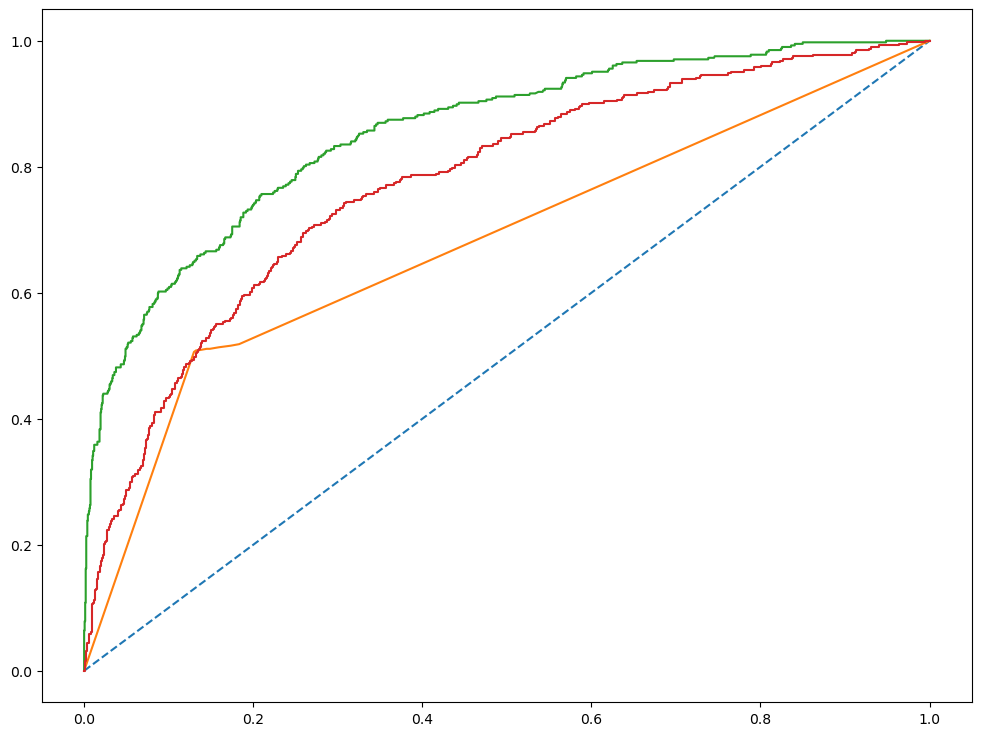

In [20]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model_tree = DecisionTreeClassifier(random_state=12345, max_depth=20)
model_tree.fit(features_train, target_train)
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model_forest = RandomForestClassifier(random_state=12345,max_depth=5, n_estimators=91)
model_forest.fit(features_train, target_train)
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model_logistic = LogisticRegression(random_state=12345, solver='liblinear')
model_logistic.fit(features_train, target_train)
probabilities_valid = model_logistic.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')


## Борьба с дисбалансом

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [22]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(target_upsampled.value_counts())

1    4888
0    4778
Name: exited, dtype: int64


In [23]:
best_model_tree_upsmple = None
best_result_upsmple = 0
for depth in range(1, 21):
    model_tree_upsmple = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_upsmple.fit(features_upsampled, target_upsampled)
    predicted_valid = model_tree_upsmple.predict(features_valid)
    print('Max depth:', depth,'F1-score:', f1_score(target_valid, predicted_valid))
    result = f1_score(target_valid, predicted_valid)
    
    if best_result_upsmple < result:
        best_result_upsmple = result
        max_depth_upsmple = depth
        best_model_tree_upsmple = model_tree_upsmple

print("Лучшая F-мера", best_result_upsmple, 'cо значением глубины =', max_depth_upsmple)
probabilities_valid = model_tree_upsmple.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)

Max depth: 1 F1-score: 0.48914069877242683
Max depth: 2 F1-score: 0.5110701107011071
Max depth: 3 F1-score: 0.5110701107011071
Max depth: 4 F1-score: 0.5695852534562211
Max depth: 5 F1-score: 0.5481481481481482
Max depth: 6 F1-score: 0.5764925373134328
Max depth: 7 F1-score: 0.55338904363974
Max depth: 8 F1-score: 0.5524344569288389
Max depth: 9 F1-score: 0.5476864966949953
Max depth: 10 F1-score: 0.5364372469635628
Max depth: 11 F1-score: 0.5341745531019979
Max depth: 12 F1-score: 0.535181236673774
Max depth: 13 F1-score: 0.5145317545748116
Max depth: 14 F1-score: 0.49665924276169265
Max depth: 15 F1-score: 0.4827586206896552
Max depth: 16 F1-score: 0.49467455621301776
Max depth: 17 F1-score: 0.5023809523809523
Max depth: 18 F1-score: 0.4884004884004884
Max depth: 19 F1-score: 0.5098522167487686
Max depth: 20 F1-score: 0.5098039215686275
Лучшая F-мера 0.5764925373134328 cо значением глубины = 6
AUC-ROC DecisionTreeClassifier 0.6935703037397953


In [24]:
# Код ревьюера
probabilities_valid = best_model_tree_upsmple.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)

AUC-ROC DecisionTreeClassifier 0.8343659530100209


In [25]:
best_model_forest_upsample = None
best_result_upsample = 0
best_depth_upsample = 0
best_est_upsample = 0

for estimator in range(1, 100, 5):
    for depth in range(1, 20):
        model_forest_upsample =  RandomForestClassifier(random_state=12345, n_estimators=estim, 
                                                   max_depth = depth)
        model_forest_upsample.fit(features_upsampled, target_upsampled)
        predicted_valid = model_forest_upsample.predict(features_valid)
        print('N estimators:', estimator, 'Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))
        result = f1_score(target_valid, predicted_valid) 
        
        if result > best_result_upsample:
            best_model_forest_upsample = model_forest_upsample
            best_result_upsample = result
            best_depth_upsample = depth
            best_est_upsample = estim

print("Лучшая F-мера", best_result_upsample, 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth_upsample,
                                                                                           best_est_upsample))
probabilities_valid = model_forest_upsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)

N estimators: 1 Глубина: 1 F1: 0.520220588235294
N estimators: 1 Глубина: 2 F1: 0.5372585096596136
N estimators: 1 Глубина: 3 F1: 0.5629202689721422
N estimators: 1 Глубина: 4 F1: 0.5705939629990263
N estimators: 1 Глубина: 5 F1: 0.6017699115044247
N estimators: 1 Глубина: 6 F1: 0.6096579476861167
N estimators: 1 Глубина: 7 F1: 0.60790273556231
N estimators: 1 Глубина: 8 F1: 0.6219895287958115
N estimators: 1 Глубина: 9 F1: 0.6234042553191489
N estimators: 1 Глубина: 10 F1: 0.6262403528114664
N estimators: 1 Глубина: 11 F1: 0.6213151927437641
N estimators: 1 Глубина: 12 F1: 0.624413145539906
N estimators: 1 Глубина: 13 F1: 0.6184049079754602
N estimators: 1 Глубина: 14 F1: 0.6317103620474408
N estimators: 1 Глубина: 15 F1: 0.6169665809768637
N estimators: 1 Глубина: 16 F1: 0.6258148631029987
N estimators: 1 Глубина: 17 F1: 0.6131578947368422
N estimators: 1 Глубина: 18 F1: 0.6236842105263157
N estimators: 1 Глубина: 19 F1: 0.6174496644295302
N estimators: 6 Глубина: 1 F1: 0.52022058823

N estimators: 41 Глубина: 10 F1: 0.6262403528114664
N estimators: 41 Глубина: 11 F1: 0.6213151927437641
N estimators: 41 Глубина: 12 F1: 0.624413145539906
N estimators: 41 Глубина: 13 F1: 0.6184049079754602
N estimators: 41 Глубина: 14 F1: 0.6317103620474408
N estimators: 41 Глубина: 15 F1: 0.6169665809768637
N estimators: 41 Глубина: 16 F1: 0.6258148631029987
N estimators: 41 Глубина: 17 F1: 0.6131578947368422
N estimators: 41 Глубина: 18 F1: 0.6236842105263157
N estimators: 41 Глубина: 19 F1: 0.6174496644295302
N estimators: 46 Глубина: 1 F1: 0.520220588235294
N estimators: 46 Глубина: 2 F1: 0.5372585096596136
N estimators: 46 Глубина: 3 F1: 0.5629202689721422
N estimators: 46 Глубина: 4 F1: 0.5705939629990263
N estimators: 46 Глубина: 5 F1: 0.6017699115044247
N estimators: 46 Глубина: 6 F1: 0.6096579476861167
N estimators: 46 Глубина: 7 F1: 0.60790273556231
N estimators: 46 Глубина: 8 F1: 0.6219895287958115
N estimators: 46 Глубина: 9 F1: 0.6234042553191489
N estimators: 46 Глубина:

N estimators: 81 Глубина: 18 F1: 0.6236842105263157
N estimators: 81 Глубина: 19 F1: 0.6174496644295302
N estimators: 86 Глубина: 1 F1: 0.520220588235294
N estimators: 86 Глубина: 2 F1: 0.5372585096596136
N estimators: 86 Глубина: 3 F1: 0.5629202689721422
N estimators: 86 Глубина: 4 F1: 0.5705939629990263
N estimators: 86 Глубина: 5 F1: 0.6017699115044247
N estimators: 86 Глубина: 6 F1: 0.6096579476861167
N estimators: 86 Глубина: 7 F1: 0.60790273556231
N estimators: 86 Глубина: 8 F1: 0.6219895287958115
N estimators: 86 Глубина: 9 F1: 0.6234042553191489
N estimators: 86 Глубина: 10 F1: 0.6262403528114664
N estimators: 86 Глубина: 11 F1: 0.6213151927437641
N estimators: 86 Глубина: 12 F1: 0.624413145539906
N estimators: 86 Глубина: 13 F1: 0.6184049079754602
N estimators: 86 Глубина: 14 F1: 0.6317103620474408
N estimators: 86 Глубина: 15 F1: 0.6169665809768637
N estimators: 86 Глубина: 16 F1: 0.6258148631029987
N estimators: 86 Глубина: 17 F1: 0.6131578947368422
N estimators: 86 Глубина:

In [26]:
# Код ревьюера
probabilities_valid = best_model_forest_upsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)

AUC-ROC DecisionTreeClassifier 0.8614670140093869


In [27]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [28]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [29]:
print(target_downsampled.value_counts())

1    1222
0    1194
Name: exited, dtype: int64


In [30]:
best_model_tree_downsample = None
best_result_downsample = 0

for depth in range(1, 21):
    model_tree_downsample = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_downsample.fit(features_downsampled, target_downsampled)
    predicted_valid = model_tree_downsample.predict(features_valid)
    print('Max depth:', depth,'F1-score:', f1_score(target_valid, predicted_valid))
    result = f1_score(target_valid, predicted_valid)
    
    if best_result_downsample < result:
        best_result_downsample = result
        max_depth_downsample = depth
        best_model_tree_downsample = model_tree_downsample

print("Лучшая F-мера", best_result_downsample, 'cо значением глубины =', max_depth_downsample)
probabilities_valid = model_tree_downsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)

Max depth: 1 F1-score: 0.48914069877242683
Max depth: 2 F1-score: 0.5110701107011071
Max depth: 3 F1-score: 0.5110701107011071
Max depth: 4 F1-score: 0.5695852534562211
Max depth: 5 F1-score: 0.5415986949429037
Max depth: 6 F1-score: 0.5515463917525774
Max depth: 7 F1-score: 0.558904109589041
Max depth: 8 F1-score: 0.5665071770334927
Max depth: 9 F1-score: 0.5306859205776173
Max depth: 10 F1-score: 0.535288725939505
Max depth: 11 F1-score: 0.5148514851485149
Max depth: 12 F1-score: 0.47889750215331606
Max depth: 13 F1-score: 0.4835355285961872
Max depth: 14 F1-score: 0.46643717728055073
Max depth: 15 F1-score: 0.46626814688300594
Max depth: 16 F1-score: 0.47189097103918226
Max depth: 17 F1-score: 0.47386172006745364
Max depth: 18 F1-score: 0.4785894206549118
Max depth: 19 F1-score: 0.4785894206549118
Max depth: 20 F1-score: 0.4785894206549118
Лучшая F-мера 0.5695852534562211 cо значением глубины = 4
AUC-ROC DecisionTreeClassifier 0.6935001257035156


In [31]:
# Код ревьюера
probabilities_valid = best_model_tree_downsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)

AUC-ROC DecisionTreeClassifier 0.8289398797873374


In [32]:
best_model_forest_downsample = None
best_result_downsample = 0
best_depth_downsample = 0
best_est_downsample = 0

for estimator in range(1, 100, 5):
    for depth in range(1, 20):
        model_forest_downsample =  RandomForestClassifier(random_state=12345, n_estimators=estim, 
                                                   max_depth = depth)
        model_forest_downsample.fit(features_downsampled, target_downsampled)
        predicted_valid = model_forest_downsample.predict(features_valid)
        print('N estimators:', estimator, 'Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))
        result = f1_score(target_valid, predicted_valid) 
        
        if result > best_result_downsample:
            best_model_forest_downsample = model_forest_downsample
            best_result_downsample = result
            best_depth_downsample = depth
            best_est_downsample = estim

print("Лучшая F-мера", best_result_downsample, 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth_downsample,
                                                                                           best_est_downsample))
probabilities_valid = model_forest_downsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)

N estimators: 1 Глубина: 1 F1: 0.5239923224568138
N estimators: 1 Глубина: 2 F1: 0.5387523629489602
N estimators: 1 Глубина: 3 F1: 0.5622568093385215
N estimators: 1 Глубина: 4 F1: 0.5780463242698892
N estimators: 1 Глубина: 5 F1: 0.5838264299802761
N estimators: 1 Глубина: 6 F1: 0.6146044624746451
N estimators: 1 Глубина: 7 F1: 0.6058174523570713
N estimators: 1 Глубина: 8 F1: 0.6074672048435923
N estimators: 1 Глубина: 9 F1: 0.6078431372549019
N estimators: 1 Глубина: 10 F1: 0.6076696165191741
N estimators: 1 Глубина: 11 F1: 0.6019607843137255
N estimators: 1 Глубина: 12 F1: 0.5998052580331061
N estimators: 1 Глубина: 13 F1: 0.5948026948989413
N estimators: 1 Глубина: 14 F1: 0.5990338164251208
N estimators: 1 Глубина: 15 F1: 0.5826001955034212
N estimators: 1 Глубина: 16 F1: 0.5955383123181377
N estimators: 1 Глубина: 17 F1: 0.596116504854369
N estimators: 1 Глубина: 18 F1: 0.5959498553519769
N estimators: 1 Глубина: 19 F1: 0.5859374999999999
N estimators: 6 Глубина: 1 F1: 0.52399232

N estimators: 41 Глубина: 9 F1: 0.6078431372549019
N estimators: 41 Глубина: 10 F1: 0.6076696165191741
N estimators: 41 Глубина: 11 F1: 0.6019607843137255
N estimators: 41 Глубина: 12 F1: 0.5998052580331061
N estimators: 41 Глубина: 13 F1: 0.5948026948989413
N estimators: 41 Глубина: 14 F1: 0.5990338164251208
N estimators: 41 Глубина: 15 F1: 0.5826001955034212
N estimators: 41 Глубина: 16 F1: 0.5955383123181377
N estimators: 41 Глубина: 17 F1: 0.596116504854369
N estimators: 41 Глубина: 18 F1: 0.5959498553519769
N estimators: 41 Глубина: 19 F1: 0.5859374999999999
N estimators: 46 Глубина: 1 F1: 0.5239923224568138
N estimators: 46 Глубина: 2 F1: 0.5387523629489602
N estimators: 46 Глубина: 3 F1: 0.5622568093385215
N estimators: 46 Глубина: 4 F1: 0.5780463242698892
N estimators: 46 Глубина: 5 F1: 0.5838264299802761
N estimators: 46 Глубина: 6 F1: 0.6146044624746451
N estimators: 46 Глубина: 7 F1: 0.6058174523570713
N estimators: 46 Глубина: 8 F1: 0.6074672048435923
N estimators: 46 Глуби

N estimators: 81 Глубина: 17 F1: 0.596116504854369
N estimators: 81 Глубина: 18 F1: 0.5959498553519769
N estimators: 81 Глубина: 19 F1: 0.5859374999999999
N estimators: 86 Глубина: 1 F1: 0.5239923224568138
N estimators: 86 Глубина: 2 F1: 0.5387523629489602
N estimators: 86 Глубина: 3 F1: 0.5622568093385215
N estimators: 86 Глубина: 4 F1: 0.5780463242698892
N estimators: 86 Глубина: 5 F1: 0.5838264299802761
N estimators: 86 Глубина: 6 F1: 0.6146044624746451
N estimators: 86 Глубина: 7 F1: 0.6058174523570713
N estimators: 86 Глубина: 8 F1: 0.6074672048435923
N estimators: 86 Глубина: 9 F1: 0.6078431372549019
N estimators: 86 Глубина: 10 F1: 0.6076696165191741
N estimators: 86 Глубина: 11 F1: 0.6019607843137255
N estimators: 86 Глубина: 12 F1: 0.5998052580331061
N estimators: 86 Глубина: 13 F1: 0.5948026948989413
N estimators: 86 Глубина: 14 F1: 0.5990338164251208
N estimators: 86 Глубина: 15 F1: 0.5826001955034212
N estimators: 86 Глубина: 16 F1: 0.5955383123181377
N estimators: 86 Глуби

In [33]:
# Код ревьюера
probabilities_valid = best_model_forest_downsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)

AUC-ROC DecisionTreeClassifier 0.8568553144824331


## Тестирование модели

In [34]:
features_full_train = pd.concat([features_train, features_valid])
target_full_train = pd.concat([target_train, target_valid])

In [35]:
features_upsampled, target_upsampled = upsample(features_full_train, target_full_train, 4)

In [36]:
model = RandomForestClassifier(random_state=12345, n_estimators= 96, 
                                                   max_depth = 14)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
f1_score(target_test, predicted_test)

0.5984848484848484

In [37]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
probabilities_one_test

array([0.09169755, 0.34900697, 0.27976026, ..., 0.01019769, 0.68038509,
       0.10337922])

In [38]:
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('auc_roc', auc_roc)

auc_roc 0.8632239013695931


## Вывод

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*